<div>    
    <span style="color: #6abad2; font-size: 18px; font-weight: bold;">School student profile (Data Set) Overview:</span>
</div>

<div>
    <span style="color: #2E8B57;"> Data set provides, 15,000 high school students who maintained profiles on a popular social networking platform during the period spanning 2006 to 2009. The data was collected uniformly over these years and provides valuable insights into the online activities and interests of adolescents during that time frame.

The dataset was obtained by crawling profiles from the social network and subsequently processed using text mining techniques to extract information about student interests. Specifically, the dataset includes counts of the 37 most dominant words found in the profiles, such as "football" and "shopping," indicating the prevalence of various topics among the student population.

In addition to interest-related data, the dataset also includes essential demographic information about each student, including their graduation year (gradyear), gender, age at the time of the survey, and the number of contacts or friends they had on the social network (NumberOffriends).</span>
</div>

<div>    
    <span style="color: #6abad2; font-size: 16px; font-weight: bold;">Load data set :</span>
</div>

In [166]:
import pandas as pd
import numpy as np
# Load dataset
df_original = pd.read_csv(r'Clustering_Marketing.csv')
df_original.head()

,gradyear,gender,age,NumberOffriends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2007,NaN,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2007,F,17.41,49,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,2007,F,17.511,41,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1
3,2006,F,NaN,36,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2008,F,16.657,1,0,0,0,0,0,1,...,0,0,0,3,0,0,0,0,0,0


In [167]:
print(f"Age total null : {df_original['age'].isnull().sum()}")
print(f"Gender total null : {df_original['gender'].isnull().sum()}")

Age total null : 2496
Gender total null : 1337


###         ================= Exploratory Data Analysis (EDA) =====================

#### impute  'age' missing values with mean

In [169]:
df_original['age'] = df_original['age'].replace(['unknown'], np.nan)
df_original['age'] = pd.to_numeric(df_original['age'], errors='coerce')  # Coerce invalid values to NaN
df_original['age'] = df_original['age'].fillna(df_original['age'].mean())
print(f"Age total null after mean replace : {df_original['age'].isnull().sum()}")
print(f"Gender total null : {df_original['gender'].isnull().sum()}")

Age total null after mean replace : 0
Gender total null : 1337


#### Impute missing values of gender using RandomForestRegressor.

In [170]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
df_encode_gender = df_original.copy()
# Assuming df_original is already defined
# Step 1: Separate rows with and without missing values in 'gender'
train_data = df_original[df_original["gender"].notna()].copy()  # Explicitly make a copy
test_data = df_original[df_original["gender"].isna()].copy()    # Explicitly make a copy

print(f"Train data missing gender: {train_data['gender'].isna().sum()}")
print(f"Test data missing gender: {test_data['gender'].isna().sum()}")

# Encode 'gender' as numeric
label_encoder = LabelEncoder()
train_data['gender'] = label_encoder.fit_transform(train_data['gender'])

# Prepare training data
X_train = train_data.drop("gender", axis=1)
y_train = train_data["gender"]

# Fit the model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Prepare test data
X_test = test_data.drop("gender", axis=1)

# Predict missing genders
predicted_genders = model.predict(X_test)

# Convert predictions back to the original gender labels
predicted_genders_labels = label_encoder.inverse_transform(predicted_genders.round().astype(int))

# Step 4: Push predictions into the original dataset
df_encode_gender.loc[df_encode_gender["gender"].isna(), "gender"] = predicted_genders_labels

# Verify the updated dataset
print("Updated dataset with imputed 'gender':")
print(f"Gender Null values after impute: {df_encode_gender['gender'].isnull().sum()}")


Train data missing gender: 0
Test data missing gender: 1337
Updated dataset with imputed 'gender':
Gender Null values after impute: 0


In [171]:
gender_counts = df_encode_gender['gender'].value_counts()
print(f"Gender counts: {gender_counts}")

Gender counts: gender
F    12279
M     2721
Name: count, dtype: int64


#### Apply SMOTE for resampling: Due to the class imbalancing in gender feature - F=12279 and M=2721, 

In [172]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
df_smote = df_encode_gender.copy()

# Step 1: Label Encode the gender column
label_encoder = LabelEncoder()
df_smote['gender'] = label_encoder.fit_transform(df_encode_gender['gender'])  # F -> 0, M -> 1

# Step 2: Separate features (X) and target (y)
X = df_smote.drop('gender', axis=1)
y = df_smote['gender']

# Step 3: Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Step 4: Convert back to DataFrame
df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), 
                          pd.DataFrame(y_resampled, columns=['gender'])], axis=1)

# Decode the gender column back to original labels if needed
df_resampled['gender'] = label_encoder.inverse_transform(df_resampled['gender'])

## Label encode of gender
df_resampled['gender'] = label_encoder.fit_transform(df_resampled['gender'])  # F -> 0, M -> 1

# Display gender counts the balanced dataset
print(f"After Class balance for Gender : {df_resampled['gender'].value_counts()}")


After Class balance for Gender : gender
0    12279
1    12279
Name: count, dtype: int64


###  ======================== Feature Engineering ==========================

#### Remove gender and grapear feature which is not much important.

In [173]:
df_resampled = df_resampled.drop(columns=['gender','gradyear']) 

#### Check Skewness of Feature's data

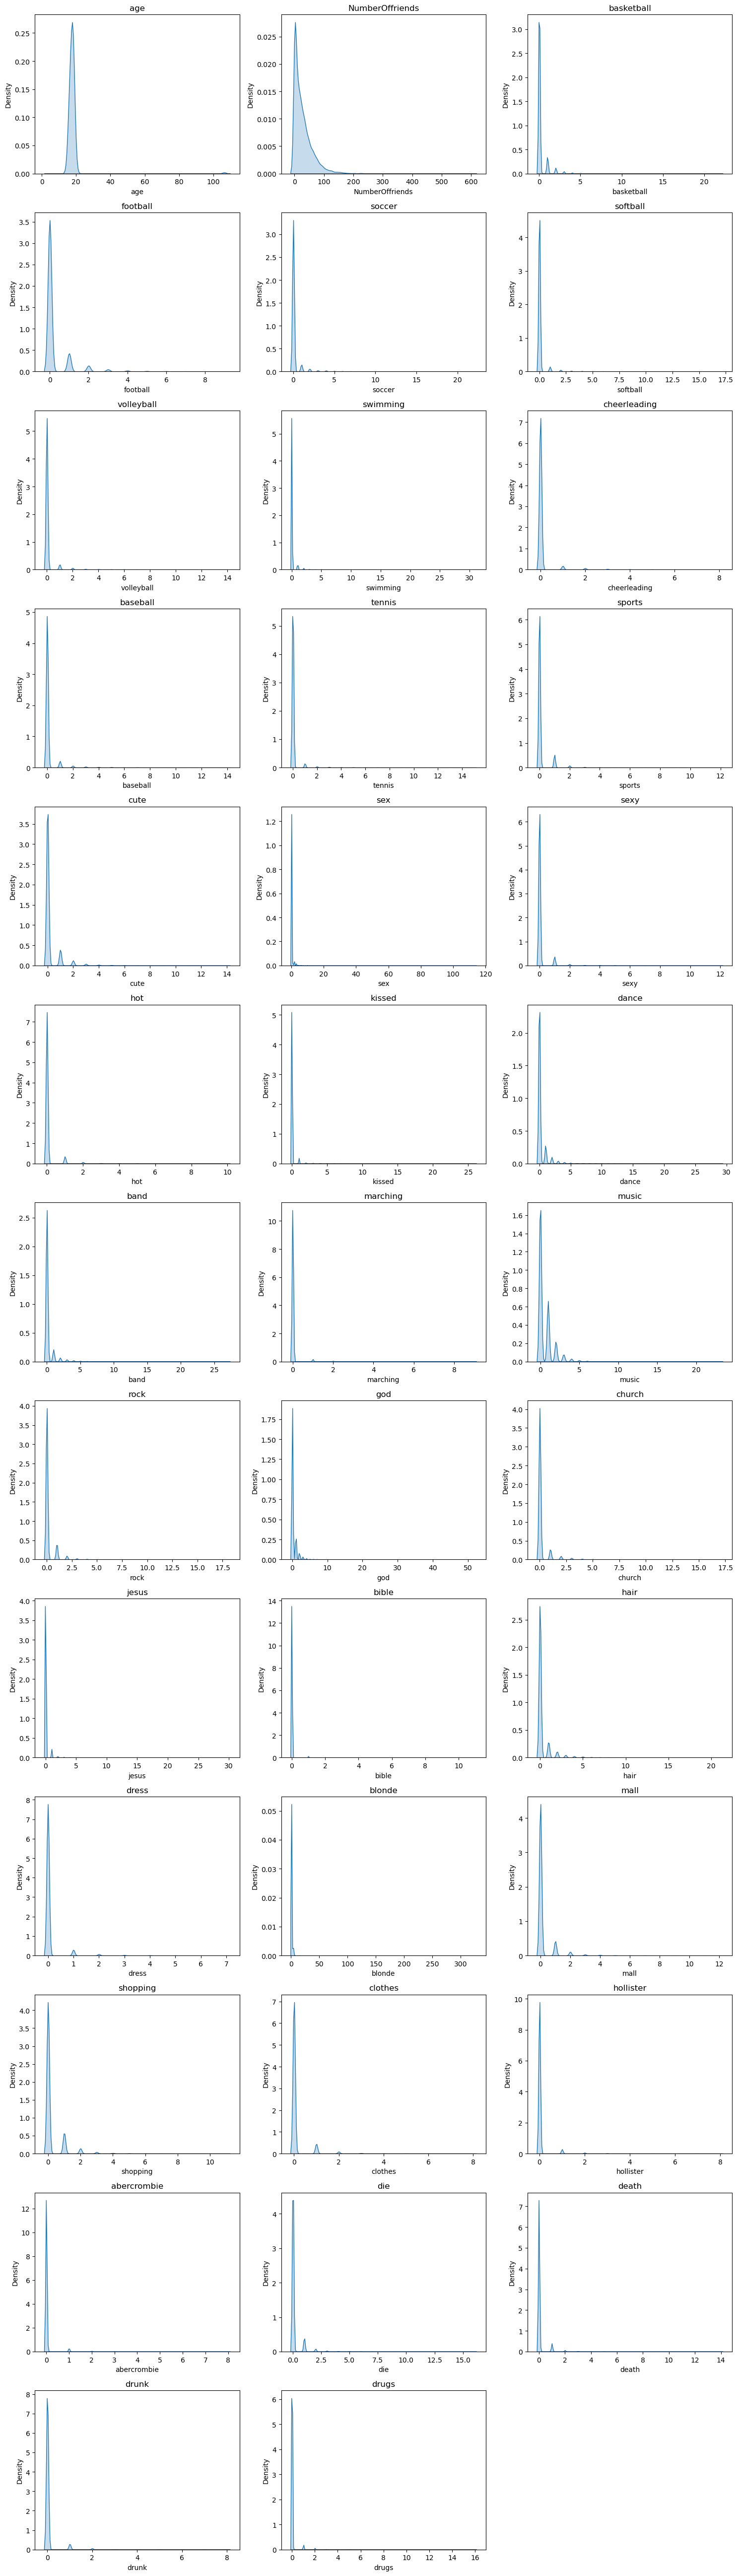

In [174]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Example: Create a sample DataFrame with 13 features
import numpy as np
# Set the number of rows and columns for the grid
n_features = len(df_resampled.columns)
n_cols = 3
n_rows = -(-n_features // n_cols)  # Ceiling division

# Create the figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()  # Flatten to easily iterate

# Plot each feature's KDE
for i, feature in enumerate(df_resampled.columns):
    sns.kdeplot(data=df_resampled[feature], ax=axes[i], fill=True)
    axes[i].set_title(feature)

# Hide any extra subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


#### Check outliers 

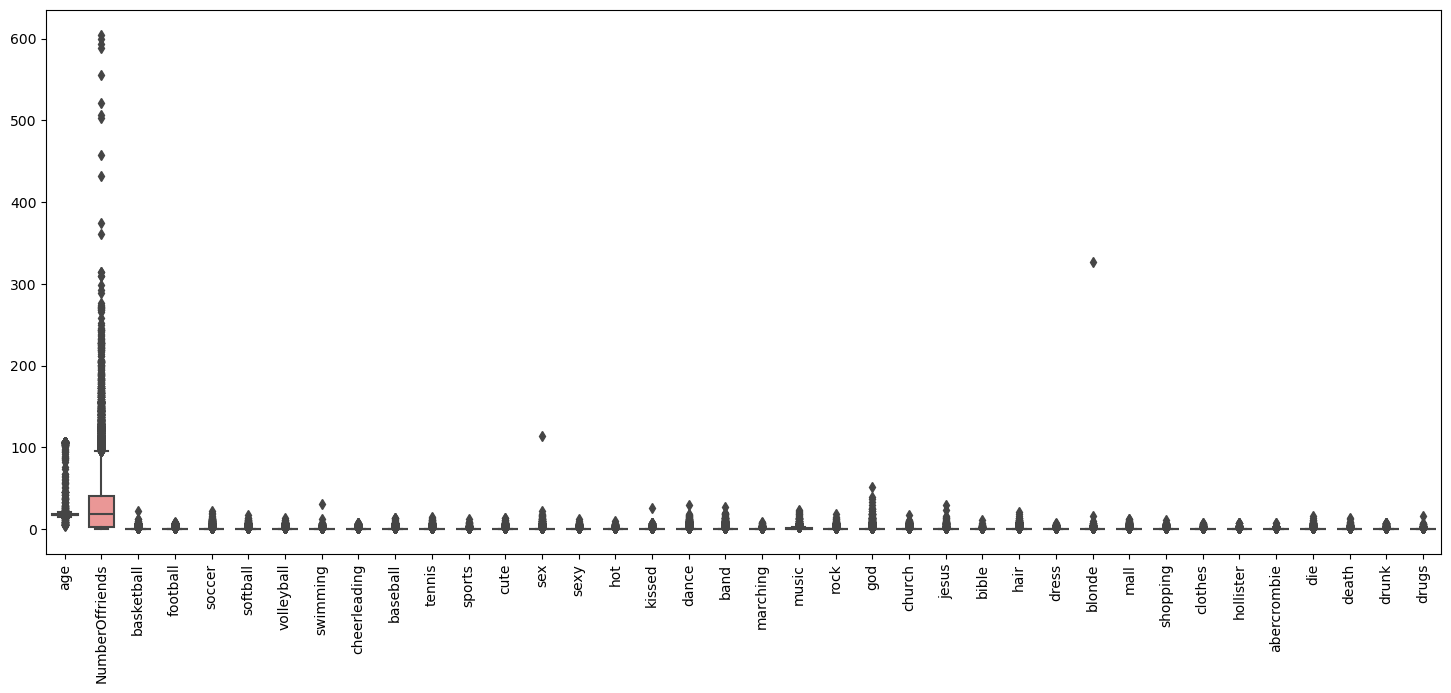

In [175]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set figure size (increase width for better label visibility)
plt.figure(figsize=(18, 8))  # Adjust width and height to your preference

# Create boxplot with wider boxes for better spacing
sns.boxplot(data=df_resampled, width=0.7)  # Adjust width for better box size

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, ha='center')  # Ensure label alignment and rotation

# Adjust space between labels and chart for clarity
plt.subplots_adjust(bottom=0.2)

plt.show()


#### Skewness table for all features

In [87]:
import pandas as pd

# Assuming df is your DataFrame
# Calculate skewness for all columns
skewness = df_resampled.skew().reset_index()
skewness.columns = ['Column', 'Skewness']

# Create a styled DataFrame
styled_skewness = skewness.style.set_table_styles(
    [
        {'selector': 'thead th', 'props': [('background-color', '#3E4149'), ('color', 'white'), ('text-align', 'center')]},
        {'selector': 'tbody td', 'props': [('border', '1px solid black'), ('text-align', 'center')]}
    ]
).set_properties(**{'text-align': 'center'})

# Display the styled DataFrame
styled_skewness

,Column,Skewness
0,age,11.307936
1,NumberOffriends,3.369088
2,basketball,5.946086
3,football,4.157755
4,soccer,8.292498
5,softball,10.074827
6,volleyball,9.477595
7,swimming,18.064531
8,cheerleading,8.902783
9,baseball,8.217805


#### Yeo-Johnson transformation

In [177]:
import pandas as pd
from scipy.stats import yeojohnson
# Apply Yeo-Johnson transformation
transformed_data = {}
lambdas = {}  # Store the lambda values for each column
for column in df_resampled.columns:
    transformed_data[column], lambdas[column] = yeojohnson(df_resampled[column])

# Create a new DataFrame with the transformed data
transformed_df = pd.DataFrame(transformed_data)
# Shift all values to ensure positivity
shift_value = abs(transformed_df.min().min()) + 1
transformed_df += shift_value

#### Preserve data after Transformation : 

In [178]:
db_transform = transformed_df.copy()

#### Capping Outlier : Using IQR method

In [180]:
import pandas as pd
import numpy as np
df_resampled = transformed_df.copy()
df_remove_outliers = df_resampled.copy()
columns = df_resampled.columns

# Cap the outliers at 1st and 99th percentile
for column in columns:
    if df_remove_outliers[column].dtype != 'object':  # Ignore categorical columns
        Q1 = df_remove_outliers[column].quantile(0.25)
        Q3 = df_remove_outliers[column].quantile(0.75)
        IQR = Q3 - Q1
        # Calculate the lower and upper bounds using 1.5 * IQR
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_remove_outliers[column] = df_remove_outliers[column].clip(lower=lower_bound, upper=upper_bound)
        

In [ ]:
#### AFter Capping Outlier : Box plot 

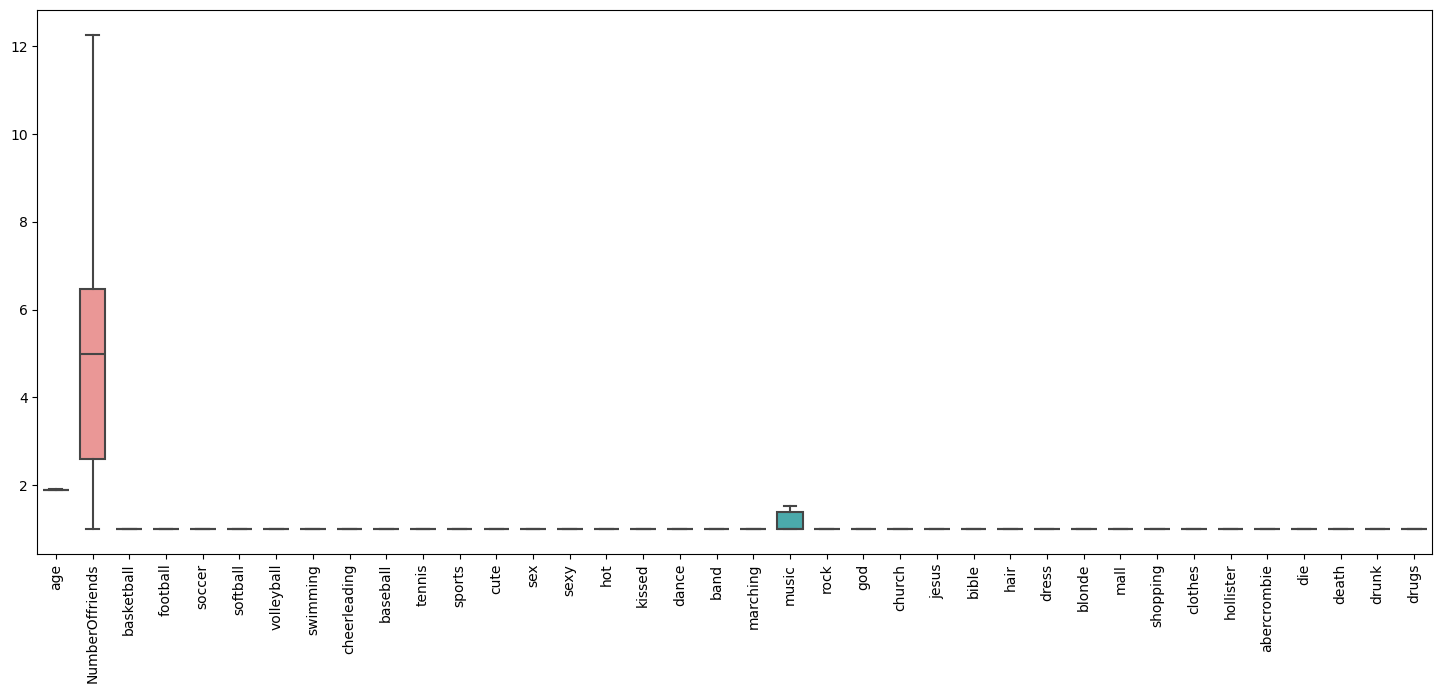

In [181]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set figure size (increase width for better label visibility)
plt.figure(figsize=(18, 8))  # Adjust width and height to your preference

# Create boxplot with wider boxes for better spacing
sns.boxplot(data=df_remove_outliers, width=0.7)  # Adjust width for better box size

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, ha='center')  # Ensure label alignment and rotation

# Adjust space between labels and chart for clarity
plt.subplots_adjust(bottom=0.2)

plt.show()


### ==================== Create MODEL : CLUSTERING =======================

#### K-MEAN

In [184]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
df_resampled = df_remove_outliers.copy()
# Scaling the data (optional, but helps in clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_resampled)

#### K-MEAN custer with range(6,13) cluster

In [185]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Scaling the data (optional, but helps in clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_remove_outliers)
data = df_remove_outliers.copy()
# Apply K-means clustering with k=6-13
for cluster_count in range(4,10):
    kmeans = KMeans(n_clusters=cluster_count, random_state=42)
    data['Cluster'] = kmeans.fit_predict(X_scaled)
    # Calculate silhouette score
    sil_score = silhouette_score(X_scaled, data['Cluster'])
    print(f"Silhouette Score clusters: {cluster_count} : {sil_score}")

Silhouette Score clusters: 6 : 0.40678031633179224
Silhouette Score clusters: 7 : 0.40127739654973155
Silhouette Score clusters: 8 : 0.3990232844274842
Silhouette Score clusters: 9 : 0.37701373670276866
Silhouette Score clusters: 10 : 0.37865252651608283
Silhouette Score clusters: 11 : 0.37232719723055546
Silhouette Score clusters: 12 : 0.37135694957350956


#### DB-SCAN apply for Clustering.

In [186]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Apply DBSCAN
dbscan = DBSCAN(eps=7.0, min_samples=30)  # Adjust `eps` and `min_samples` as needed
data['Cluster_DBSCAN'] = dbscan.fit_predict(X_scaled)

# Check the number of clusters (excluding noise, labeled as -1)
n_clusters = len(set(data['Cluster_DBSCAN']) - {-1})
print(f"Number of clusters found (excluding noise): {n_clusters}")

# Evaluate Silhouette Score (only if at least 2 clusters are formed)
if n_clusters > 1:
    sil_score = silhouette_score(X_reduced, data['Cluster_DBSCAN'])
    print(f"Silhouette Score for DBSCAN: {sil_score}")
else:
    print("DBSCAN did not find sufficient clusters.")


Number of clusters found (excluding noise): 1
DBSCAN did not find sufficient clusters.


#### Appy HDBSCAN

In [152]:
#!pip install hdbscan

In [153]:
import hdbscan
from sklearn.metrics import silhouette_score

# Apply HDBSCAN
hdbscan_clusterer = hdbscan.HDBSCAN(min_samples=200, min_cluster_size=30, metric='euclidean')  # Adjust parameters as needed
data['Cluster_HDBSCAN'] = hdbscan_clusterer.fit_predict(X_scaled)

# Extract cluster labels
labels = data['Cluster_HDBSCAN']

# Check number of clusters (excluding noise, labeled as -1)
n_clusters = len(set(labels) - {-1})
print(f"Number of clusters found (excluding noise): {n_clusters}")

# Calculate Silhouette Score (only if at least 2 clusters are found)
if n_clusters > 1:
    sil_score = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score for HDBSCAN: {sil_score}")
else:
    print("HDBSCAN did not find sufficient clusters.")


Number of clusters found (excluding noise): 18
Silhouette Score for HDBSCAN: -0.2210357246888267


<div>
    <span style="color: #2E8B57; font-size: 18px; font-weight: bold;">:: Clustering Results ::</span>    
</div>
<div>
    <span style="color: #2E8B57; font-size: 16px;">The "DBSCAN" have good  Silhouette score -52, with two clusters, and K-means have highest Silhouette score with 8-clusters. But HDBCAN have very poor score which is not acceptable.
</div>
